# Wide and Deep Hybrid!
https://github.com/microsoft/recommenders/blob/main/examples/00_quick_start/wide_deep_movielens.ipynb

## Prepare

In [ ]:
conda install numpy=1.20

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.VERSION)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 1.15.5
GPUs:
 [{'device_name': 'Tesla V100-SXM2-16GB', 'total_memory': 16160.5, 'free_memory': 15854.0}]


In [2]:
import fun
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType, StructType, StructField
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import HashingTF, CountVectorizer, VectorAssembler
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [3]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
    evaluator.recall_at_k.__name__
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True
# Item feature column name
ITEM_FEAT_COL = 'genres'

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [4]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

## Import and prepare data

In [5]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    # The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
    data_full = movielens.load_pandas_df(
        size=MOVIELENS_DATA_SIZE,
        header=[USER_COL, ITEM_COL, RATING_COL, 'timestamp'],
        genres_col=ITEM_FEAT_COL,
        title_col='title'
    )
    display(data_full.head())

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.77kKB/s]


,userID,itemID,rating,timestamp,title,genres
0,196,242,3.0,881250949,Kolya (1996),Comedy
1,63,242,3.0,875747190,Kolya (1996),Comedy
2,226,242,5.0,883888671,Kolya (1996),Comedy
3,154,242,3.0,879138235,Kolya (1996),Comedy
4,306,242,5.0,876503793,Kolya (1996),Comedy


In [6]:
data = data_full[[USER_COL, ITEM_COL, RATING_COL,ITEM_FEAT_COL]]

Encode genres col

In [7]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("Genres:", genres_encoder.classes_)
    display(data.head())

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


/usr4/cs542sp/nannkat/.conda/envs/condarec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,userID,itemID,rating,genres
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Train and test split + get user item pairs

In [8]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.75, seed=RANDOM_SEED)
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

75000 train samples and 25000 test samples


Spark datasets

In [9]:
data_full_spark = fun.movielens_to_spark(data_full, schema = fun.get_movielens_schema())

traintestschema = StructType(
    (StructField("UserId", IntegerType()),
    StructField("MovieId", IntegerType()),
    StructField("Rating", FloatType())))

train_df_spark = fun.movielens_to_spark(train[[USER_COL, ITEM_COL, RATING_COL]], schema = traintestschema)
test_df_spark = fun.movielens_to_spark(test[[USER_COL, ITEM_COL, RATING_COL]], schema = traintestschema)


Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+------+-------+------+---------+------------+------+
|UserId|MovieId|Rating|Timestamp|       title|genres|
+------+-------+------+---------+------------+------+
|   196|    242|   3.0|881250949|Kolya (1996)|Comedy|
|    63|    242|   3.0|875747190|Kolya (1996)|Comedy|
|   226|    242|   5.0|883888671|Kolya (1996)|Comedy|
|   154|    242|   3.0|879138235|Kolya (1996)|Comedy|
|   306|    242|   5.0|876503793|Kolya (1996)|Comedy|
+------+-------+------+---------+------------+------+
only showing top 5 rows

Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)

+------+-------+------+
|UserId|MovieId|Rating|
+------+-------+------+
|   405

In [10]:
feature_data = fun.create_feature_data(data_full_spark)

User-item pairs in the dataset

In [11]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 1682 items and 943 users in the dataset


## Train and predict WIDE DEEP

Build

In [12]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

In [13]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265, 465 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(19 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(24 ...
	 NumericColumn(key='genres', shape=(19,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [14]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

user-item df

In [15]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

print(ranking_pool.shape[0])

1511126


train

In [16]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [17]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.logging.set_verbosity(tf.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

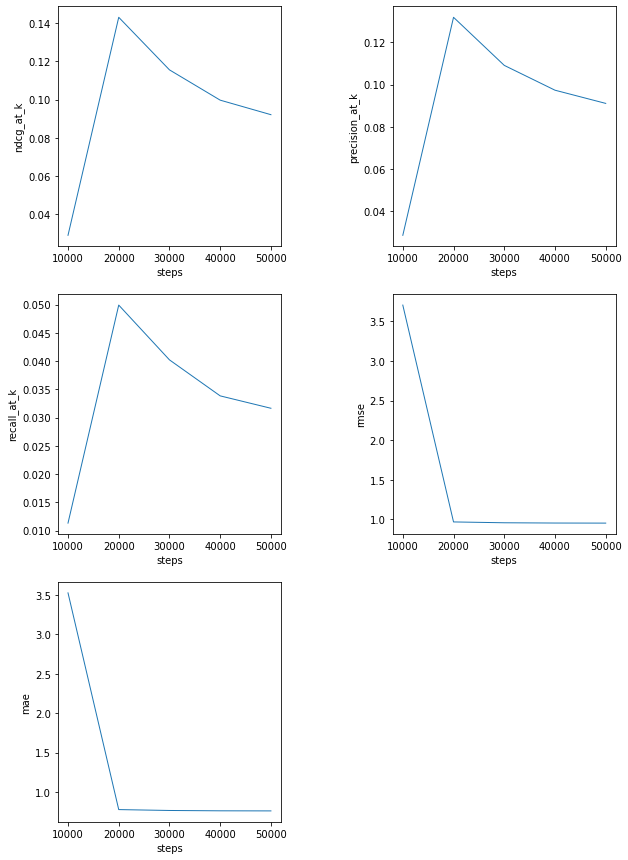

In [18]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

Create top k

In [ ]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

## Evaluate

### Create top k

In [19]:
predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
prediction_df = ranking_pool.copy()
prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/1295843.1.academic-gpu/tmp0pzda23g/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
prediction_df.head()

,userID,itemID,genres,prediction
0,626,1422,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2.124280
1,818,219,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",3.148307
2,75,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",3.647772
3,352,1491,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",2.611854
4,68,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",3.440133


In [21]:
schema = StructType(
    (StructField("UserId", IntegerType()),
    StructField("MovieId", IntegerType()),
    StructField("Rating", FloatType())))

top_all = fun.movielens_to_spark(prediction_df[['userID', 'itemID', 'prediction']], schema = fun.get_predictions_schema())

Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- prediction: float (nullable = true)

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|   626|   1422| 2.1242802|
|   818|    219|  3.148307|
|    75|   1639|  3.647772|
|   352|   1491|  2.611854|
|    68|   1639|  3.440133|
+------+-------+----------+
only showing top 5 rows



In [22]:
window = Window.partitionBy('UserId').orderBy(F.col("prediction").desc())
top_k_reco = top_all.select("*", F.row_number().over(window).alias("rank")).filter(F.col("rank") <= TOP_K).drop("rank")

In [23]:
top_k_reco.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|   148|    318| 4.7889366|
|   148|    285| 4.5706253|
|   148|    603|  4.530361|
|   148|     64|  4.508941|
|   148|    513|  4.487127|
|   148|    114| 4.4849634|
|   148|    479|  4.476581|
|   148|    657|  4.453797|
|   148|    963|  4.429183|
|   148|    199|  4.425315|
|   463|    483| 3.9573576|
|   463|    408| 3.9274223|
|   463|    318| 3.8789165|
|   463|     12| 3.8376253|
|   463|    169|  3.809069|
|   463|    479| 3.7828517|
|   463|     98| 3.7819278|
|   463|    114| 3.7510061|
|   463|     64| 3.7303421|
|   463|    178| 3.7297487|
+------+-------+----------+
only showing top 20 rows



## Make topk reco with examples

In [24]:
top_k_pd = fun.movielens_to_pandas(top_k_reco)
top_k_pd.head()

,UserId,MovieId,prediction
0,148,318,4.788937
1,148,285,4.570625
2,148,603,4.530361
3,148,64,4.508941
4,148,513,4.487127


In [28]:
data_full_new = data_full.rename(columns={"userID": "UserId", "itemID": "MovieId"})
data_full_new.head()

,UserId,MovieId,rating,timestamp,title,genres
0,196,242,3.0,881250949,Kolya (1996),Comedy
1,63,242,3.0,875747190,Kolya (1996),Comedy
2,226,242,5.0,883888671,Kolya (1996),Comedy
3,154,242,3.0,879138235,Kolya (1996),Comedy
4,306,242,5.0,876503793,Kolya (1996),Comedy


In [29]:
top_k_with_info = (top_k_pd.join(data_full_new[['MovieId', 'title', 'genres']].drop_duplicates().set_index('MovieId'), 
                                on='MovieId', 
                                how='inner').sort_values(by=['UserId', 'prediction'], ascending=False))
display(top_k_with_info.head(30))

,UserId,MovieId,prediction,title,genres
7310,943,483,4.478840,Casablanca (1942),Drama|Romance|War
7311,943,169,4.464947,"Wrong Trousers, The (1993)",Animation|Comedy
7312,943,408,4.417659,"Close Shave, A (1995)",Animation|Comedy|Thriller
7313,943,134,4.373812,Citizen Kane (1941),Drama
7314,943,114,4.345226,Wallace & Gromit: The Best of Aardman Animatio...,Animation
7315,943,479,4.297452,Vertigo (1958),Mystery|Thriller
7316,943,480,4.256416,North by Northwest (1959),Comedy|Thriller
7317,943,272,4.250051,Good Will Hunting (1997),Drama
7318,943,603,4.217871,Rear Window (1954),Mystery|Thriller
7319,943,651,4.203549,Glory (1989),Action|Drama|War


In [30]:
top_k_with_info.to_csv("wd_topk_visual_results.csv", index = False)

### Rating - using their way

In [36]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/1288347.1.academic-gpu/tmps7fntgag/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.9516662983205283, 'mae': 0.7558373137438297}


### Ranking - using their way

In [37]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/1288347.1.academic-gpu/tmps7fntgag/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.09103324768088135, 'precision_at_k': 0.08382820784729587, 'recall_at_k': 0.06031416542234978}


### Diversity, Rating, Ranking - using our methods

In [51]:
diversity_collaborative, diversity_content, ranking, rating = fun.get_metrics(train_df_spark, test_df_spark, top_k_reco, top_all, feature_data, top_k = TOP_K)

In [52]:
metrics = fun. display_metrics(diversity_collaborative, diversity_content, ranking, rating)
metrics

,Metric,Score,Range,Criteria
0,Collaborative Diversity,0.717454,"[0,1]",The closer to 1 the better
1,Collaborative Serendipity,0.793943,"[0,1]",The closer to 1 the better
2,Collaborative Novelty,9.188981,>=0,Inverse popularity. The higher the better
3,Content Diversity,0.883584,"[0,1]",The closer to 1 the better
4,Content Serendipity,0.889802,"[0,1]",The closer to 1 the better
5,Content Novelty,9.188981,>=0,Inverse popularity. The higher the better
6,RMSE,0.951666,>0,The smaller the better
7,MAE,0.755837,>=0,The smaller the better
8,R Squared,0.290805,<=1,The closer to 1 the better
9,Precision@k,0.083828,"[0,1]",The closer to 1 the better. Grows with k


In [53]:
metrics.to_csv("wide_deep_20k_results.csv", index = False)